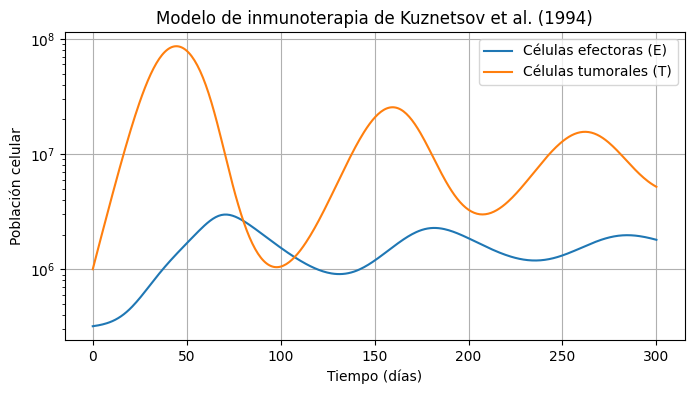

In [ ]:
# Importando librerías 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Parámetros
s = 1.3e4      # tasa basal de llegada de efectores
p = 0.1245     # proliferación de efectores inducida por tumor
g = 2.0e7      # parámetro de saturación
m = 3.422e-10  # tasa de inactivación de efectores
n = 1.101e-7   # tasa de destrucción tumoral
d = 0.0412     # muerte natural de efectores
a = 0.18       # tasa de crecimiento tumoral
b = 2.0e-9     # capacidad de carga tumoral

# Sistema de ecuaciones diferenciales
def kuz_system(t, vars):
    E, T = vars  # Efectores e inmunes
    dEdt = s + (p * E * T) / (g + T) - m * E * T - d * E
    dTdt = a * T * (1 - b * T) - n * E * T
    return [dEdt, dTdt]

# Condiciones iniciales
E0 = 3.2e5   # efectores iniciales
T0 = 1.0e6   # tumor inicial
initial_conditions = [E0, T0]

# Intervalo de tiempo para la simulación
time_span = (0, 300)  # días
t_eval = np.linspace(*time_span, 400)

# Resolver el sistema
solution = solve_ivp(kuz_system, time_span, initial_conditions, t_eval=t_eval, method='LSODA')

# Extraer la solución
t_values = solution.t
E_values = solution.y[0]
T_values = solution.y[1]

# Gráfico de poblaciones en el tiempo
plt.figure(figsize=(8, 4))
plt.plot(t_values, E_values, label='Células efectoras (E)')
plt.plot(t_values, T_values, label='Células tumorales (T)')
plt.xlabel('Tiempo (días)')
plt.ylabel('Población celular')
plt.title('Modelo de inmunoterapia de Kuznetsov et al. (1994)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

In [28]:
#Convertimos a tensores
t_values = torch.tensor(t_values, dtype=torch.float32).view(-1, 1)
E_values = torch.tensor(E_values, dtype=torch.float32).view(-1, 1)
T_values = torch.tensor(T_values, dtype=torch.float32).view(-1, 1)

In [29]:
# Datos observacionales ruidosos
torch.manual_seed(10)

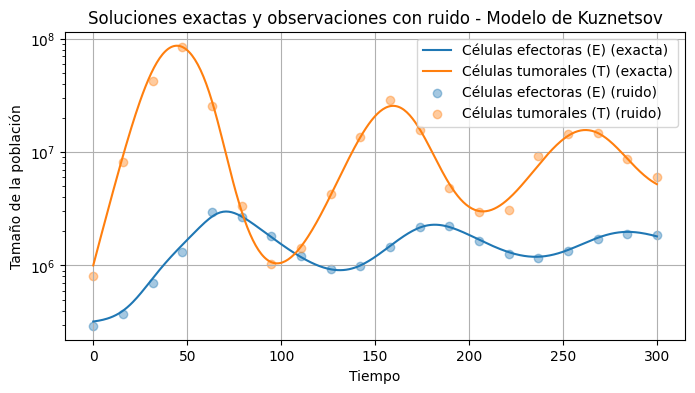

In [30]:
# Número de muestras equiespaciadas
n_obs = 20

# Índices equiespaciados desde 0 hasta el último índice
idx_obs = torch.linspace(0, t_values.shape[0] - 1, steps=n_obs).long()
t_obs = t_values[idx_obs]

# Extraemos los valores exactos de E y T en esos tiempos
E_obs = E_values[idx_obs]
T_obs = T_values[idx_obs]

# Porcentaje de ruido relativo por punto
frac = 0.10

# normal truncada para evitar outliers muy grandes
zE = torch.clamp(torch.randn_like(E_obs), -2.0, 2.0)
zT = torch.clamp(torch.randn_like(T_obs), -2.0, 2.0)

E_obs_r = torch.clamp(E_obs + frac * E_obs * zE, min=0.0)
T_obs_r = torch.clamp(T_obs + frac * T_obs * zT, min=0.0)

#visualización
plt.figure(figsize=(8, 4))
plt.plot(t_values, E_values, label='Células efectoras (E) (exacta)')
plt.plot(t_values, T_values, label='Células tumorales (T) (exacta)')
plt.scatter(t_obs, E_obs_r, label="Células efectoras (E) (ruido)", alpha=0.4)
plt.scatter(t_obs, T_obs_r, label="Células tumorales (T) (ruido)", alpha=0.4)
plt.xlabel('Tiempo')
plt.ylabel('Tamaño de la población')
plt.title("Soluciones exactas y observaciones con ruido - Modelo de Kuznetsov")
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

In [31]:
# Red neuronal
class FCN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(n_input, n_hidden),activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(n_hidden, n_hidden),activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Iter 0 | Loss=0.310509 | BC=0.021501 | Phys=0.381646 | Obs=0.270194 | p=0.123500 | d=0.042200


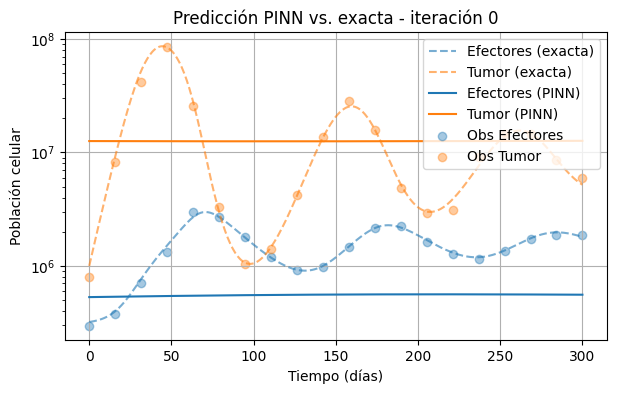

Iter 2500 | Loss=2.804654 | BC=0.001263 | Phys=27.974363 | Obs=0.007092 | p=0.151794 | d=0.048126
Iter 5000 | Loss=0.000290 | BC=0.000014 | Phys=0.001722 | Obs=0.000117 | p=0.128753 | d=0.042967


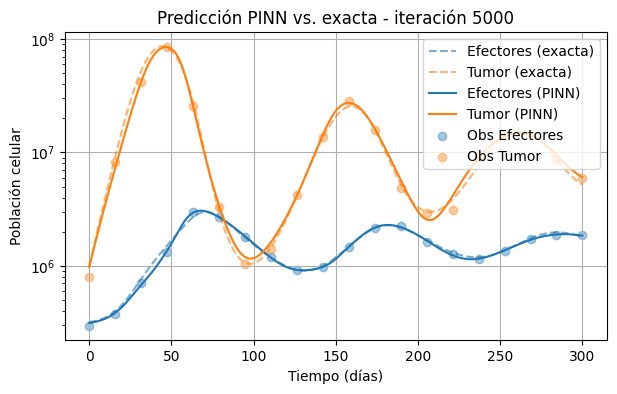

Iter 7500 | Loss=0.000237 | BC=0.000004 | Phys=0.001346 | Obs=0.000103 | p=0.127676 | d=0.042294
Iter 10000 | Loss=0.000149 | BC=0.000006 | Phys=0.001030 | Obs=0.000045 | p=0.127426 | d=0.041931


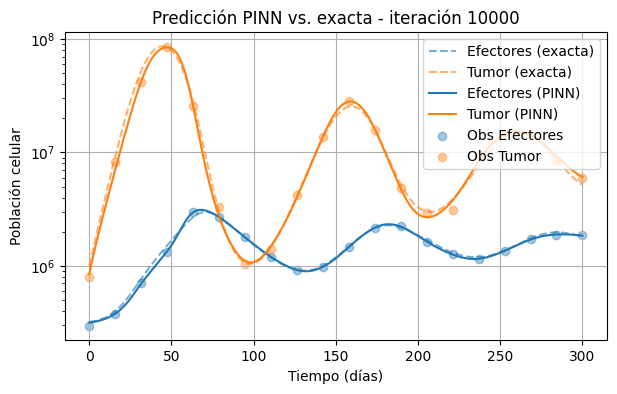

Iter 12500 | Loss=0.000143 | BC=0.000007 | Phys=0.001011 | Obs=0.000041 | p=0.127673 | d=0.042034
Iter 15000 | Loss=0.001288 | BC=0.000005 | Phys=0.003201 | Obs=0.000968 | p=0.132943 | d=0.043344


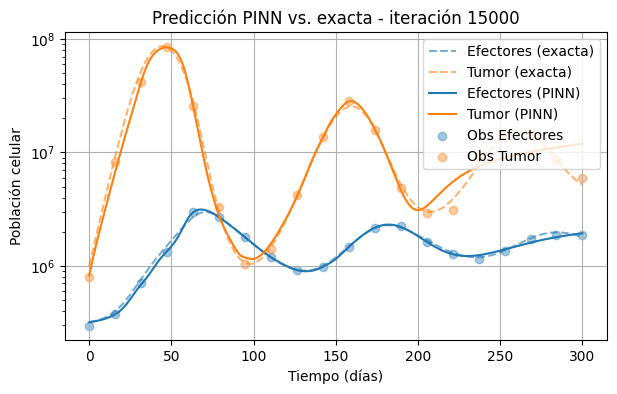

Iter 17500 | Loss=0.000155 | BC=0.000010 | Phys=0.001037 | Obs=0.000050 | p=0.127912 | d=0.042117
Iter 20000 | Loss=0.000133 | BC=0.000012 | Phys=0.000930 | Obs=0.000039 | p=0.127435 | d=0.041904


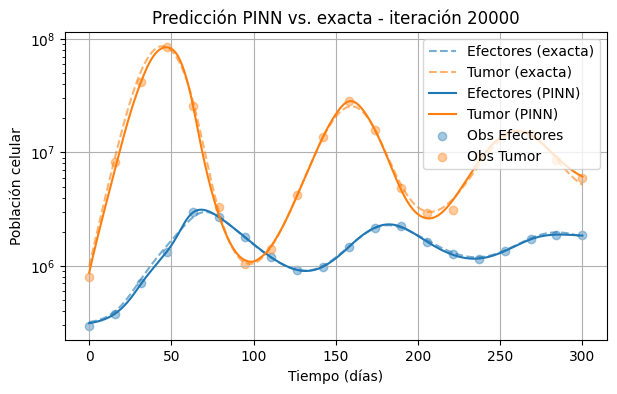

In [32]:
torch.manual_seed(10)

# Red
pinn = FCN(1, 2, 32, 5)

# Parámetros entrenables
p_t = torch.nn.Parameter(torch.tensor([p], dtype=torch.float32))
d_t = torch.nn.Parameter(torch.tensor([d], dtype=torch.float32))

optimizer = torch.optim.Adam(list(pinn.parameters()) + [p_t, d_t], lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30000, eta_min=1e-7)

# Pesos
lambda_bc = 0.1
lambda_phys =0.1
lambda_obs = 1

# Normalización
def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

def denormalize(xn, xmin, xmax):
    return xn * (xmax - xmin) + xmin

# Rangos
t_min, t_max = t_values.min(), t_values.max()
E_min, E_max = E_values.min(), E_values.max()
T_min, T_max = T_values.min(), T_values.max()

# Tiempos
t_boundary = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
t_physics  = torch.tensor(solution.t, dtype=torch.float32).view(-1, 1).requires_grad_(True)
t_test     = torch.linspace(time_span[0], time_span[1], 300).view(-1, 1)

# Normalizaciones
t_boundary_n = normalize(t_boundary, t_min, t_max).detach().requires_grad_(True)
t_physics_n = normalize(t_physics, t_min, t_max).detach().requires_grad_(True)
t_test_n = normalize(t_test, t_min, t_max)

t_obs_n = normalize(t_obs, t_min, t_max).detach().requires_grad_(True)
E_obs_r_n = normalize(E_obs_r, E_min, E_max)
T_obs_r_n = normalize(T_obs_r, T_min, T_max)

# Condiciones iniciales normalizadas
E0_norm = normalize(torch.tensor([[E0]], dtype=torch.float32), E_min, E_max)
T0_norm = normalize(torch.tensor([[T0]], dtype=torch.float32), T_min, T_max)

# Parámetros fijos
s_t, g_t, m_t, n_t_fixed, a_t_fixed, b_t_fixed = [torch.tensor(val, dtype=torch.float32) for val in [s, g, m, n, a, b]]

# Listas de pérdidas
loss_total_list, loss_bc_list, loss_phys_list, loss_obs_list = [], [], [], []
p_list, d_list = [], []

# Entrenamiento
for i in range(20001):
    optimizer.zero_grad()

    # Condiciones iniciales
    E0_pred_n, T0_pred_n = pinn(t_boundary_n)[0]
    loss_bc = (E0_pred_n - E0_norm.squeeze())**2 + (T0_pred_n - T0_norm.squeeze())**2

    # Física
    pred_phys_n = pinn(t_physics_n)
    E_pred_n, T_pred_n = pred_phys_n[:, 0:1], pred_phys_n[:, 1:2]

    E_pred = denormalize(E_pred_n, E_min, E_max)
    T_pred = denormalize(T_pred_n, T_min, T_max)

    dE_dt_n = torch.autograd.grad(E_pred_n, t_physics_n, torch.ones_like(E_pred_n), create_graph=True)[0]
    dT_dt_n = torch.autograd.grad(T_pred_n, t_physics_n, torch.ones_like(T_pred_n), create_graph=True)[0]

    dE_dt = dE_dt_n / (t_max - t_min) * (E_max - E_min)
    dT_dt = dT_dt_n / (t_max - t_min) * (T_max - T_min)

    # ODE con p y d entrenables
    ode1 = dE_dt - (s_t + (p_t * E_pred * T_pred)/(g_t + T_pred)
                    - m_t * E_pred * T_pred - d_t * E_pred)

    ode2 = dT_dt - (a_t_fixed * T_pred * (1 - b_t_fixed * T_pred)
                    - n_t_fixed * E_pred * T_pred)

    # Escalado
    scale1 = torch.abs(s_t) + torch.abs((p_t*E_pred*T_pred)/(g_t+T_pred)) \
           + torch.abs(m_t*E_pred*T_pred) + torch.abs(d_t*E_pred) + 1e-8
    scale2 = torch.abs(a_t_fixed*T_pred*(1-b_t_fixed*T_pred)) \
           + torch.abs(n_t_fixed*E_pred*T_pred) + 1e-8

    loss_phys = torch.mean((ode1/scale1)**2) + torch.mean((ode2/scale2)**2)

    # Observaciones
    pred_obs_n = pinn(t_obs_n)
    E_pred_obs_n, T_pred_obs_n = pred_obs_n[:, 0], pred_obs_n[:, 1]
    loss_obs = torch.mean((E_pred_obs_n - E_obs_r_n.squeeze())**2) + torch.mean((T_pred_obs_n - T_obs_r_n.squeeze())**2)

    # Total
    loss = lambda_bc*loss_bc + lambda_phys*loss_phys + lambda_obs*loss_obs
    loss.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)
    optimizer.step()

    # Mantener p y d no-negativos
    with torch.no_grad():
        p_t.copy_(torch.relu(p_t))
        d_t.copy_(torch.relu(d_t))

    scheduler.step()

    # Pérdidas
    loss_total_list.append(loss.item())
    loss_bc_list.append(loss_bc.item())
    loss_phys_list.append(loss_phys.item())
    loss_obs_list.append(loss_obs.item())
    p_list.append(p_t.item())
    d_list.append(d_t.item())

    if i % 2500 == 0:
        print(f"Iter {i} | Loss={loss.item():.6f} | BC={loss_bc.item():.6f} "
              f"| Phys={loss_phys.item():.6f} | Obs={loss_obs.item():.6f} "
              f"| p={p_t.item():.6f} | d={d_t.item():.6f}")

    if i % 5000 == 0:
        with torch.no_grad():
            pred_test_n = pinn(t_test_n)
            E_pred_test = denormalize(pred_test_n[:, 0], E_min, E_max).numpy()
            T_pred_test = denormalize(pred_test_n[:, 1], T_min, T_max).numpy()

            plt.figure(figsize=(7, 4))
            plt.plot(t_values.numpy(), E_values.numpy(), '--', color='tab:blue', alpha=0.6, label='Efectores (exacta)')
            plt.plot(t_values.numpy(), T_values.numpy(), '--', color='tab:orange', alpha=0.6, label='Tumor (exacta)')
            plt.plot(t_test.numpy(), E_pred_test, color='tab:blue', label='Efectores (PINN)')
            plt.plot(t_test.numpy(), T_pred_test, color='tab:orange', label='Tumor (PINN)')
            plt.scatter(t_obs.numpy(), E_obs_r.numpy(), color='tab:blue', alpha=0.4, label='Obs Efectores')
            plt.scatter(t_obs.numpy(), T_obs_r.numpy(), color='tab:orange', alpha=0.4, label='Obs Tumor')
            plt.xlabel("Tiempo (días)"); plt.ylabel("Población celular")
            plt.title(f"Predicción PINN vs. exacta - iteración {i}")
            plt.legend(loc='upper right'); plt.grid(True); plt.yscale('log'); plt.show()


In [36]:
import pandas as pd

# Crear DataFrame con valores reales y estimados
data = {'Variable': ['p', 'd'],'Valor real': [p, d],'Valor estimado': [p_t.item(), d_t.item()]}
df = pd.DataFrame(data)
pd.options.display.float_format = '{:,.6f}'.format
display(df.style.hide(axis="index"))


Variable,Valor real,Valor estimado
p,0.124500,0.127435
d,0.041200,0.041904


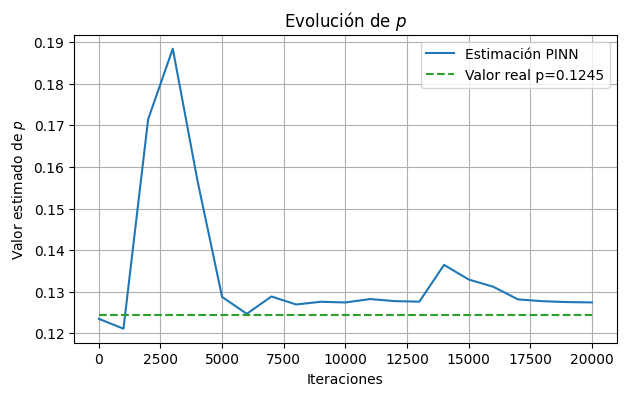

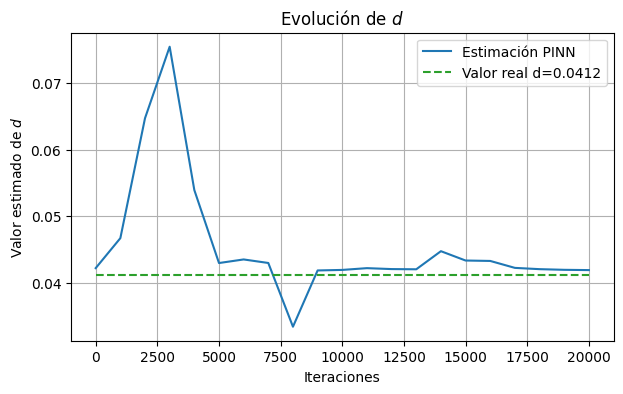

In [34]:
# Iteraciones
pasos = np.arange(len(p_list))
pasos_filtrados = pasos[::1000]

p_filtrados = [p_list[i] for i in pasos_filtrados]
d_filtrados = [d_list[i] for i in pasos_filtrados]

# Curva de p
plt.figure(figsize=(7,4))
plt.plot(pasos_filtrados, p_filtrados, label="Estimación PINN", color="tab:blue")
plt.hlines(p, pasos_filtrados[0], pasos_filtrados[-1],
           label=f"Valor real p={p}", color="tab:green", linestyles="--")
plt.title(r"Evolución de $p$")
plt.xlabel("Iteraciones")
plt.ylabel(r"Valor estimado de $p$")
plt.legend()
plt.grid(True)
plt.show()

# Curva de d
plt.figure(figsize=(7,4))
plt.plot(pasos_filtrados, d_filtrados, label="Estimación PINN", color="tab:blue")
plt.hlines(d, pasos_filtrados[0], pasos_filtrados[-1],
           label=f"Valor real d={d}", color="tab:green", linestyles="--")
plt.title(r"Evolución de $d$")
plt.xlabel("Iteraciones")
plt.ylabel(r"Valor estimado de $d$")
plt.legend()
plt.grid(True)
plt.show()


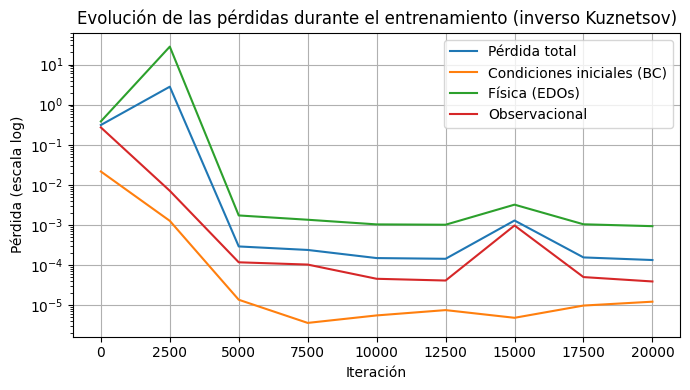

In [35]:
# Índices de iteración cada 2500 pasos
iters = list(range(0, len(loss_total_list), 2500))

# Submuestreo de las listas de pérdidas
loss_total_sub = loss_total_list[:: 2500]
loss_bc_sub    = loss_bc_list[:: 2500]
loss_phys_sub  = loss_phys_list[:: 2500]
loss_obs_sub   = loss_obs_list[:: 2500]

# Gráfica de pérdidas
plt.figure(figsize=(7, 4))
plt.plot(iters, loss_total_sub, label='Pérdida total', color='tab:blue')
plt.plot(iters, loss_bc_sub,    label='Condiciones iniciales (BC)', color='tab:orange')
plt.plot(iters, loss_phys_sub,  label='Física (EDOs)', color='tab:green')
plt.plot(iters, loss_obs_sub,   label='Observacional', color='tab:red')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida (escala log)')
plt.title('Evolución de las pérdidas durante el entrenamiento (inverso Kuznetsov)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
